# Convolutional Neural Network for Image Classification

### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
import torch.optim as optim

import os
import cv2

### Building CNN with 8 layers

In [39]:
class CNN8Net(nn.Module):
    def __init__(self):
        super(CNN8Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )                
        
        self.classifier = nn.Sequential(
            nn.Flatten(),            
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = self.classifier(x)
        return x

model = CNN8Net()

feature_map_size 12544


#### Defining Transformation for Training and Validation Data

In [25]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### Defining Transformation for Test Data

In [41]:
transformtest = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### Loaders for Training and Validation Datasets

In [19]:
train_dir = 'F:/Computer Vision Yeshiva/Dog_heart/Train'
val_dir = 'F:/Computer Vision Yeshiva/Dog_heart/Valid'

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Training and Evaluating CNN Model

#### Training the model using SGD optimiser for the first 20 epochs

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

best_val_loss = float('inf')
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    scheduler.step(avg_loss)  # or scheduler.step() for StepLR
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)

    val_loss /= len(val_loader)
    val_acc = val_correct.double() / len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {running_loss/len(train_loader):.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Acc: {val_acc:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_simplemodel.pth')

torch.save(model.state_dict(), 'simple_cnn.pth')


Epoch [1/20], Loss: 1.0908
Epoch 1/20, Train Loss: 1.0908, Val Loss: 1.0948, Val Acc: 0.4550
Epoch [2/20], Loss: 1.0904
Epoch 2/20, Train Loss: 1.0904, Val Loss: 1.0948, Val Acc: 0.4550
Epoch [3/20], Loss: 1.0901
Epoch 3/20, Train Loss: 1.0901, Val Loss: 1.0949, Val Acc: 0.4550
Epoch [4/20], Loss: 1.0902
Epoch 4/20, Train Loss: 1.0902, Val Loss: 1.0948, Val Acc: 0.4550
Epoch [5/20], Loss: 1.0904
Epoch 5/20, Train Loss: 1.0904, Val Loss: 1.0948, Val Acc: 0.4550
Epoch [6/20], Loss: 1.0900
Epoch 6/20, Train Loss: 1.0900, Val Loss: 1.0948, Val Acc: 0.4550
Epoch [7/20], Loss: 1.0907
Epoch 7/20, Train Loss: 1.0907, Val Loss: 1.0947, Val Acc: 0.4550
Epoch [8/20], Loss: 1.0905
Epoch 8/20, Train Loss: 1.0905, Val Loss: 1.0947, Val Acc: 0.4550
Epoch [9/20], Loss: 1.0902
Epoch 9/20, Train Loss: 1.0902, Val Loss: 1.0948, Val Acc: 0.4550
Epoch [10/20], Loss: 1.0904
Epoch 10/20, Train Loss: 1.0904, Val Loss: 1.0947, Val Acc: 0.4550
Epoch [11/20], Loss: 1.0902
Epoch 11/20, Train Loss: 1.0902, Val Los

#### Training the model using Adam optimiser with learning rate of 0.0001 for the next 20 epochs

In [44]:
optimizer1 = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

best_val_loss = float('inf')
early_stopping_patience = 10
early_stopping_counter = 0

num_epochs = 40

for epoch in range(21, num_epochs+1):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:        
        optimizer1.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer1.step()

        running_loss += loss.item()
    scheduler1.step(running_loss/len(train_loader))
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)

    val_loss /= len(val_loader)
    val_acc = val_correct.double() / len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {running_loss/len(train_loader):.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Acc: {val_acc:.4f}')

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model_sgd.pth')
    else:
        early_stopping_counter += 1    

Epoch 22/40, Train Loss: 1.0276, Val Loss: 1.1779, Val Acc: 0.3800
Epoch 23/40, Train Loss: 0.9999, Val Loss: 1.1199, Val Acc: 0.4400
Epoch 24/40, Train Loss: 0.9722, Val Loss: 1.1169, Val Acc: 0.4550
Epoch 25/40, Train Loss: 0.9598, Val Loss: 1.0487, Val Acc: 0.4250
Epoch 26/40, Train Loss: 0.9519, Val Loss: 1.1256, Val Acc: 0.4000
Epoch 27/40, Train Loss: 0.9408, Val Loss: 1.0537, Val Acc: 0.4250
Epoch 28/40, Train Loss: 0.9254, Val Loss: 0.9887, Val Acc: 0.4400
Epoch 29/40, Train Loss: 0.9323, Val Loss: 0.9711, Val Acc: 0.5050
Epoch 30/40, Train Loss: 0.9079, Val Loss: 1.0681, Val Acc: 0.4400
Epoch 31/40, Train Loss: 0.9029, Val Loss: 0.9807, Val Acc: 0.5000
Epoch 32/40, Train Loss: 0.9017, Val Loss: 0.9777, Val Acc: 0.4600
Epoch 33/40, Train Loss: 0.8627, Val Loss: 0.8259, Val Acc: 0.5400
Epoch 34/40, Train Loss: 0.8279, Val Loss: 0.8618, Val Acc: 0.5650
Epoch 35/40, Train Loss: 0.7737, Val Loss: 0.9382, Val Acc: 0.5550
Epoch 36/40, Train Loss: 0.7797, Val Loss: 0.8468, Val Acc: 0.

#### Training the model using Adam optimiser with learning rate of 0.001 for the next 20 epochs

In [46]:
optimizer1 = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

best_val_loss = float('inf')
early_stopping_patience = 10
early_stopping_counter = 0

num_epochs = 60

for epoch in range(40, num_epochs+1):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:        
        optimizer1.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer1.step()

        running_loss += loss.item()
    scheduler1.step(running_loss/len(train_loader))
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)

    val_loss /= len(val_loader)
    val_acc = val_correct.double() / len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {running_loss/len(train_loader):.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Acc: {val_acc:.4f}')

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model_sgd.pth')
    else:
        early_stopping_counter += 1    

Epoch 41/60, Train Loss: 0.8541, Val Loss: 0.7576, Val Acc: 0.6250
Epoch 42/60, Train Loss: 0.7626, Val Loss: 0.8492, Val Acc: 0.5750
Epoch 43/60, Train Loss: 0.7709, Val Loss: 0.7499, Val Acc: 0.5950
Epoch 44/60, Train Loss: 0.7371, Val Loss: 0.9315, Val Acc: 0.5200
Epoch 45/60, Train Loss: 0.7225, Val Loss: 0.8200, Val Acc: 0.6300
Epoch 46/60, Train Loss: 0.7064, Val Loss: 0.6876, Val Acc: 0.6150
Epoch 47/60, Train Loss: 0.6935, Val Loss: 0.5825, Val Acc: 0.6800
Epoch 48/60, Train Loss: 0.6788, Val Loss: 0.6373, Val Acc: 0.6900
Epoch 49/60, Train Loss: 0.6518, Val Loss: 0.6528, Val Acc: 0.6150
Epoch 50/60, Train Loss: 0.6577, Val Loss: 0.6248, Val Acc: 0.6900
Epoch 51/60, Train Loss: 0.6586, Val Loss: 0.6481, Val Acc: 0.6900
Epoch 52/60, Train Loss: 0.6534, Val Loss: 0.8253, Val Acc: 0.6050
Epoch 53/60, Train Loss: 0.6647, Val Loss: 0.6961, Val Acc: 0.6300
Epoch 54/60, Train Loss: 0.6380, Val Loss: 0.6465, Val Acc: 0.6650
Epoch 55/60, Train Loss: 0.6338, Val Loss: 0.6938, Val Acc: 0.

#### Training the model using Adam optimiser with learning rate of 0.00001 for the next 20 epochs

In [50]:
optimizer2 = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)
scheduler1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

best_val_loss = float('inf')
early_stopping_patience = 10
early_stopping_counter = 0

num_epochs = 80

for epoch in range(60, num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:        
        optimizer2.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()

        running_loss += loss.item()
    scheduler1.step(running_loss/len(train_loader))
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)

    val_loss /= len(val_loader)
    val_acc = val_correct.double() / len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {running_loss/len(train_loader):.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Acc: {val_acc:.4f}')

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model_sgd.pth')
    else:
        early_stopping_counter += 1    

Epoch 61/80, Train Loss: 0.5950, Val Loss: 0.8138, Val Acc: 0.6150
Epoch 62/80, Train Loss: 0.5634, Val Loss: 0.7245, Val Acc: 0.6500
Epoch 63/80, Train Loss: 0.5334, Val Loss: 0.6528, Val Acc: 0.6600
Epoch 64/80, Train Loss: 0.5633, Val Loss: 0.6853, Val Acc: 0.6600
Epoch 65/80, Train Loss: 0.5517, Val Loss: 0.6716, Val Acc: 0.6500
Epoch 66/80, Train Loss: 0.5425, Val Loss: 0.7265, Val Acc: 0.6600
Epoch 67/80, Train Loss: 0.5391, Val Loss: 0.7152, Val Acc: 0.6550
Epoch 68/80, Train Loss: 0.5233, Val Loss: 0.6703, Val Acc: 0.6750
Epoch 69/80, Train Loss: 0.5117, Val Loss: 0.6490, Val Acc: 0.7000
Epoch 70/80, Train Loss: 0.5419, Val Loss: 0.6674, Val Acc: 0.6750
Epoch 71/80, Train Loss: 0.5298, Val Loss: 0.6250, Val Acc: 0.6900
Epoch 72/80, Train Loss: 0.5232, Val Loss: 0.6940, Val Acc: 0.6600
Epoch 73/80, Train Loss: 0.5174, Val Loss: 0.6375, Val Acc: 0.6650
Epoch 74/80, Train Loss: 0.5114, Val Loss: 0.6950, Val Acc: 0.6800
Epoch 75/80, Train Loss: 0.5295, Val Loss: 0.6834, Val Acc: 0.

##### At the end of 80th epoch we got training loss of 0.5 and Validation Accuracy of 0.7

### Saving Model Weights

In [59]:
torch.save(model.state_dict(), 'CNNetwork_model_weights.pth')

### Loader for Test Dataset

In [42]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_filepaths = []
        self.image_filenames = []
        
        for label in os.listdir(root_dir):            
            label_dir = os.path.join(root_dir, label)
            #print("label dir", label_dir)
            self.image_filepaths.append(label_dir)
            self.image_filenames.append(label)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = self.image_filepaths[idx]
        img_name = self.image_filenames[idx]
        #image = cv2.imread(img_path)
        image = Image.open(img_path).convert("RGB")        
        if self.transform:
            image = self.transform(image)
        return image, img_path, img_name

# Create a test data loader
test_batch_size = 8
test_dataset = CustomImageDataset(root_dir='F:/Computer Vision Yeshiva/Test', transform=transformtest)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

### Making Predictions on Test Dataset

In [52]:
from PIL import Image
import pandas as pd

all_predictions = []
all_labels = []
all_file_names = []
all_file_paths = []

model.load_state_dict(torch.load('CNNetwork_model_weights.pth'))
model.eval()
with torch.no_grad():  # Disable gradient calculations for inference
    for inputs, file_paths,file_names in test_loader:
        #inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        #print("p is ", predicted)
        all_predictions.extend(predicted.cpu().numpy())
        #all_labels.extend(labels.cpu().numpy())
        all_file_names.extend(file_names)
        all_file_paths.extend(file_paths)
        
# Create a dictionary with file names and predictions
data = {'File Name': all_file_names, 'Predicted Label': all_predictions}

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
output_csv_path = 'F:/Computer Vision Yeshiva/CNNDogHeartPrediction.csv'
df.to_csv(output_csv_path, index=False, header=False)

Accuracy of the CNN8Net model on Dog Heart Test Dataset is 71%.

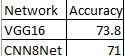

### ResearchGate paper link for Image Classification

https://www.researchgate.net/publication/382111878_Implementation_of_Convolutional_Neural_Network_for_Image_Classification

### GitHub Weight link

https://github.com/NNikhil89/CNNPrediction